# Udacity Data Scientist Capstone
## Kaggle Competition: House Prices - Advanced Regression Techniques

by Umrbek Allakulov

## Table of contents:
* [Introduction](#first-bullet)
* [Data preprocessing and descriptive statistics](#second-bullet)
     - [Preprocessing and descriptive statistics of categorical attributes](#third-bullet)
     - [Preprocessing and descriptive statistics of numerical attributes](#fourth-bullet)
         - [Continuous attributes](#5-bullet)
         - [Ordinal attributes](#6-bullet)
         - [Descriptive statistics of numerical attributes](#7-bullet)
* [Prepararation of datasets for modelling](#9-bullet)
* [Unsupervised learning](#10-bullet)
    - [Principal component analysis](#11-bullet)
    - [KMeans clustering](#13-bullet)
- [Supervised learning](#14-bullet)
    - [Feature selection](#15-bullet)
    - [Tune Hyperparameters with Randomized Search](#17-bullet)
    - [Evaluation of feature importances](#20-bullet)

## Introduction <a class="anchor" id="first-bullet"></a>

This note book contains all the code and analysis, and is submitted as part of the Capstone Project for the Data Scientist Nanodegree. The project uses datasets from a Kaggle Competition titled "House Prices - Advanced Regression Techniques". <br>


**Data descriptions as provided in the Kaggle competition webpage** <br>

The Ames Housing dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset. 

train.csv - the training set <br>
test.csv - the test set <br>
data_description.txt - full description of each column, originally prepared by Dean De Cock but lightly edited to match the column names used here <br>
sample_submission.csv - a benchmark submission from a linear regression on year and month of sale, lot square footage, and number of bedrooms

In [ ]:
# install modules
!pip install plotly
!pip install --upgrade setuptools
!pip install --upgrade pip
!pip install xgboost

In [1365]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
import plotly.offline as py
from scipy.stats import uniform, truncnorm, randint
import warnings

In [1101]:
#import datasets
df_train = pd.read_csv(r"train.csv")
df_test = pd.read_csv(r"test.csv")

In [1102]:
# replace NAs with np.nan

def fix_na(df):
    '''
    Replaces NA's with np.nan
    
    Args:
    df - DataFrame 
    
    Returns: 
    df - DataFrame where NA's are replace with np.nan
    '''
    for col in categorical_col:
        df[col] = df[col].replace("NA", np.nan)
    return df

df_train = fix_na(df_train)
df_test = fix_na(df_test)

In [1104]:
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

In [1012]:
#data description
desc = open("data_description.txt", "r")
print(desc.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

# Data preprocessing and descriptive statistics <a class="anchor" id="second-bullet"></a>

I begin by checking the presence of missing values in the training dataset and identify columns to drop. I drop the selected columns in both the training and testing datasets

In [1105]:
def percent_missing(df):
    '''
    Calculates the percentage of missing values in a dataset.
    
    Args:
    inputs: Dataset
    returns: Dataset showing the percentage of missing values per column.
    '''
    percent_missing = df.isnull().sum()* 100/len(df)
    percent_missing_df = pd.DataFrame({'col': df.columns,
                                 'percent_missing': percent_missing})
    return percent_missing_df

In [1106]:
# calculate the percentage of missing values
missing_train = percent_missing(df_train)

In [1107]:
# top 15 attributes in terms of missing values
missing_train["percent_missing"].sort_values(ascending = False).head(15)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageCond       5.547945
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
Name: percent_missing, dtype: float64

Most variables have less than 6% values missing. For this analysis, I will drop variables that have more than 18% values missing, resulting in the elimination of 5 attributes.

In [1108]:
#select columns to remove
missing_remove = list(missing_train[missing_train["percent_missing"]>19]["col"])
missing_remove

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [1109]:
train = df_train.drop(missing_remove, inplace = False, axis = 1)
test = df_test.drop(missing_remove, inplace = False, axis = 1)

In [1110]:
train.shape, test.shape

((1460, 76), (1459, 75))

## Preprocessing and descriptive statistics of categorical attributes <a class="anchor" id="third-bullet"></a>

In [1111]:
# list of categorical variables
categorical_col = ["MSSubClass","MSZoning", "Street", "LotShape", "LandContour", 
                   "Utilities", "LotConfig", "LandSlope", "Neighborhood", "Condition1",
                   "Condition2", "BldgType", "HouseStyle", "RoofStyle", "Exterior1st",
                   "Exterior2nd", "MasVnrType", "Foundation", "Heating", "Electrical", 
                   "GarageType", "SaleType", "SaleCondition", "CentralAir", "RoofMatl"]

In [1112]:
# descriptive statistics of categorical variables - part1
train[categorical_col].iloc[:, 0:13].astype(str).describe(include = 'all')

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,15,5,2,4,4,2,5,3,25,9,8,5,8
top,20,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story
freq,536,1151,1454,925,1311,1459,1052,1382,225,1260,1445,1220,726


In [1113]:
# descriptive statistics of categorical variables - part2
train[categorical_col].iloc[:, 13:].describe(include = 'all')

,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,Electrical,GarageType,SaleType,SaleCondition,CentralAir,RoofMatl
count,1460,1460,1460,1452,1460,1460,1459,1379,1460,1460,1460,1460
unique,6,15,16,4,6,6,5,6,9,6,2,8
top,Gable,VinylSd,VinylSd,None,PConc,GasA,SBrkr,Attchd,WD,Normal,Y,CompShg
freq,1141,515,504,864,647,1428,1334,870,1267,1198,1365,1434


In [1114]:
# impute categorical attributes using the most frequent value
simple_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

#fit imputer on the combined dataset
for col in categorical_col:
    simple_imputer.fit(pd.concat([train[col], test[col]], axis=0, sort=False).values.reshape(-1, 1))
    
    #apply the imputer separately to the train and test dataset
    train[col] = simple_imputer.transform(train[col].values.reshape(-1, 1))
    test[col] = simple_imputer.transform(test[col].values.reshape(-1, 1))

In [1115]:
#length of the train set - I will needed to separate the concatenated set later
train_objs_num = len(train)

#concatenate the test and train sets
dataset = pd.concat(objs = [train, test], axis=0)

# get dummies on the combined data first
dataset_preprocessed  = pd.get_dummies(dataset, columns = categorical_col, prefix = categorical_col, dummy_na = False, drop_first = True)

# separate the test and train sets from the combined dataset
train = dataset_preprocessed[:train_objs_num]
test = dataset_preprocessed[train_objs_num:]

# Preprocessing and descriptive statistics of numerical attributes <a class="anchor" id="fourth-bullet"></a>

## Continuous attributes <a class="anchor" id="5-bullet"></a>

In [1116]:
# engineer features using numeric attributes
def numeric_features(df):
    '''
    Creates new features based on continuous numerical attributes 
    
    Args:
    df: DataFrame
    
    Returns:
    df: DataFrame with new features
    '''
    
    #create new features by aggregating several existing features
    df['Total_indoor_area'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['Total_area'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'] + df['GrLivArea'] + df['GarageArea']
    df['Total_bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) + df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
    df['Total_baths'] = df['FullBath'] + 0.5 * df['HalfBath']
    df['Total_lot_area'] = df['LotFrontage'] + df['LotArea']
    df['Total_porch_area'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['ScreenPorch']
    df['Total_finished_basement'] = df['BsmtFinSF1'] + df['BsmtFinSF2']
    df['Total_porch_area'] = (df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF'])
    
    # create dummy variables that take 1 if the detail is present, 0 if absent
    df['Pool_dummy'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df['2floor_dummy'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    df['Garage_dummy'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    df['Basement_dummy'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    df['Fireplace_dummy'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
    return df

In [1117]:
train = numeric_features(train)
test = numeric_features(test)

In [1120]:
# check for null values in attributes
pd.isnull(train).sum().sort_values(ascending=False).head(15)

Total_lot_area     259
LotFrontage        259
GarageYrBlt         81
GarageFinish        81
GarageQual          81
GarageCond          81
BsmtExposure        38
BsmtFinType2        38
BsmtQual            37
BsmtCond            37
BsmtFinType1        37
MasVnrArea           8
MSZoning_FV          0
LandContour_Lvl      0
MSSubClass_150       0
dtype: int64

In [1121]:
# check the means of the numeric variables before imputing 
train[['LotFrontage','Total_lot_area','MasVnrArea', 'GarageYrBlt']].mean()

LotFrontage          70.049958
Total_lot_area    10021.748543
MasVnrArea          103.685262
GarageYrBlt        1978.506164
dtype: float64

In [1123]:


# Impute numerical continuous attributes using the closest neighbors
# numeric attibutes with missing values
num_col = ['LotFrontage','Total_lot_area','MasVnrArea', 'GarageYrBlt', 'Total_area', 'Total_bathrooms', 'BsmtFullBath', 'BsmtHalfBath',
          'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1', 'Total_indoor_area', 'BsmtFinSF2', 'Total_finished_basement', 'GarageArea', 'GarageCars']

def knn_imputer(train, test, num_col):
    '''
    Imputes null values using KNN imputer for selected columns
    
    Args:
    train: DataFrame containing training data
    test: DataFrame containing test data
    num_cols: continuous numerical columns with null values
    
    Returns:
    train and test datasets where the columns in num_cols are imputed
    '''
    #initialize imputer
    imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
    # fit imputer on the combined dataset
    for col in num_col:
        imputer.fit(pd.concat([train[col], test[col]], axis=0, sort=False).values.reshape(-1, 1))
    
    #apply the imputer separately to the train and test dataset
        train[col] = imputer.transform(train[col].values.reshape(-1, 1))
        test[col] = imputer.transform(test[col].values.reshape(-1, 1))
    
    return train, test

In [1125]:
knn_imputer(train, test, num_col)

(        Id  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
 0        1         65.0     8450            7            5       2003   
 1        2         80.0     9600            6            8       1976   
 2        3         68.0    11250            7            5       2001   
 3        4         60.0     9550            7            5       1915   
 4        5         84.0    14260            8            5       2000   
 ...    ...          ...      ...          ...          ...        ...   
 1455  1456         62.0     7917            6            5       1999   
 1456  1457         85.0    13175            6            6       1978   
 1457  1458         66.0     9042            7            9       1941   
 1458  1459         68.0     9717            5            6       1950   
 1459  1460         75.0     9937            5            6       1965   
 
       YearRemodAdd  MasVnrArea ExterQual ExterCond  ... Total_bathrooms  \
 0             2003       196.0   

In [1126]:
# check that the means of the numerical attributes have decreased after imputation 
train[['LotFrontage','Total_lot_area','MasVnrArea', 'GarageYrBlt']].mean()

LotFrontage         69.917946
Total_lot_area    9981.619489
MasVnrArea         103.677130
GarageYrBlt       1978.484374
dtype: float64

In [1127]:
# verify that only categorical attributes have missing values - to be imputed later
pd.isnull(train).sum().sort_values(ascending=False).head(12)

GarageFinish        81
GarageQual          81
GarageCond          81
BsmtFinType2        38
BsmtExposure        38
BsmtQual            37
BsmtFinType1        37
BsmtCond            37
LandContour_HLS      0
LandContour_Low      0
Utilities_NoSeWa     0
LandContour_Lvl      0
dtype: int64

## Ordinal attributes <a class="anchor" id="6-bullet"></a>

In [1128]:
# list of variables to be treated as ordinal
ordinal_col = ["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", 
               "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", "KitchenQual", 
               "Functional", "GarageFinish", "GarageQual", "GarageCond", 
               "PavedDrive"]

In [1129]:
#check for missing values in the ordianl attributes
pd.isnull(train[ordinal_col]).sum().sort_values(ascending=False)

GarageCond      81
GarageQual      81
GarageFinish    81
BsmtFinType2    38
BsmtExposure    38
BsmtFinType1    37
BsmtCond        37
BsmtQual        37
PavedDrive       0
Functional       0
KitchenQual      0
HeatingQC        0
ExterCond        0
ExterQual        0
OverallCond      0
OverallQual      0
dtype: int64

In [1131]:
# impute ordinal attributes using the most frequent value
def simple_imputer(train, test, ordinal_col):
    '''
    Imputes null values using simple imputer for selected columns
    
    Args:
    train: DataFrame containing training data
    test: DataFrame containing test data
    ordinal_col: list of ordinal attributes with null values
    
    Returns:
    train and test datasets where the columns in ordinal_col are imputed
    '''
    #initialize imputer
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    # fit imputer on the combined dataset
    for col in ordinal_col:
        imputer.fit(pd.concat([train[col], test[col]], axis=0, sort=False).values.reshape(-1, 1))
    
    #apply the imputer separately to the train and test dataset
        train[col] = imputer.transform(train[col].values.reshape(-1, 1))
        test[col] = imputer.transform(test[col].values.reshape(-1, 1))
    
    return train, test

simple_imputer(train, test, ordinal_col)

(        Id  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
 0        1         65.0     8450            7            5       2003   
 1        2         80.0     9600            6            8       1976   
 2        3         68.0    11250            7            5       2001   
 3        4         60.0     9550            7            5       1915   
 4        5         84.0    14260            8            5       2000   
 ...    ...          ...      ...          ...          ...        ...   
 1455  1456         62.0     7917            6            5       1999   
 1456  1457         85.0    13175            6            6       1978   
 1457  1458         66.0     9042            7            9       1941   
 1458  1459         68.0     9717            5            6       1950   
 1459  1460         75.0     9937            5            6       1965   
 
       YearRemodAdd  MasVnrArea ExterQual ExterCond  ... Total_bathrooms  \
 0             2003       196.0   

In [1133]:
#check if any null values left in ordinal attributes
pd.isnull(test[ordinal_col]).sum().sort_values(ascending=False)

PavedDrive      0
GarageCond      0
GarageQual      0
GarageFinish    0
Functional      0
KitchenQual     0
HeatingQC       0
BsmtFinType2    0
BsmtFinType1    0
BsmtExposure    0
BsmtCond        0
BsmtQual        0
ExterCond       0
ExterQual       0
OverallCond     0
OverallQual     0
dtype: int64

In [1134]:
#create a dictionary of columns
dict_cols = {0: ["OverallQual", "OverallCond"],
1: ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond'], 
2: ['BsmtExposure'], 
3: ['BsmtFinType1', 'BsmtFinType2'],
4: ['Functional'],
5: ['GarageFinish'], 
6: ['PavedDrive']}

In [1135]:
# create an ordered dictionary of categories
dict_cats = {0: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
1: ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
2: ['No', 'Mn', 'Av', 'Gd'],
3: ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], 
4: ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], 
5: ['Unf', 'RFn', 'Fin'],
6: ['N', 'P', 'Y']}

In [1136]:
# iterate through columns in dict_cols and encode ordinal variables of each attribute using the specific order given in dict_cats
for i in range(0, 7):
    print(dict_cats[i])
    encoder = OrdinalEncoder(categories = [dict_cats[i]])
    for col in dict_cols[i]:
        print(col)
        encoder.fit(pd.concat([train[col], test[col]], axis=0, sort=False).values.reshape(-1, 1))
        train[col] = encoder.transform(train[col].values.reshape(-1, 1))
        test[col] = encoder.transform(test[col].values.reshape(-1, 1))
        print("Finished")

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
OverallQual
Finished
OverallCond
Finished
['Po', 'Fa', 'TA', 'Gd', 'Ex']
ExterQual
Finished
ExterCond
Finished
BsmtQual
Finished
BsmtCond
Finished
HeatingQC
Finished
KitchenQual
Finished
GarageQual
Finished
GarageCond
Finished
['No', 'Mn', 'Av', 'Gd']
BsmtExposure
Finished
['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
BsmtFinType1
Finished
BsmtFinType2
Finished
['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']
Functional
Finished
['Unf', 'RFn', 'Fin']
GarageFinish
Finished
['N', 'P', 'Y']
PavedDrive
Finished


In [1137]:
#check if encoding was successful
train[['BsmtFinType2']].value_counts(), test[['BsmtFinType2']].value_counts()

(BsmtFinType2
 0.0             1294
 2.0               54
 1.0               46
 3.0               33
 4.0               19
 5.0               14
 dtype: int64,
 BsmtFinType2
 0.0             1279
 2.0               51
 1.0               41
 3.0               35
 4.0               33
 5.0               20
 dtype: int64)

In [1140]:
#check for presence of any null values in the da
pd.isnull(train).sum().sort_values(ascending=False), pd.isnull(test).sum().sort_values(ascending=False)

(Fireplace_dummy        0
 MSZoning_RM            0
 LotConfig_FR3          0
 LotConfig_FR2          0
 LotConfig_CulDSac      0
                       ..
 Exterior1st_HdBoard    0
 Exterior1st_CemntBd    0
 Exterior1st_CBlock     0
 Exterior1st_BrkFace    0
 Id                     0
 Length: 223, dtype: int64,
 SalePrice              1459
 Fireplace_dummy           0
 MSZoning_RM               0
 LotConfig_FR3             0
 LotConfig_FR2             0
                        ... 
 Exterior1st_HdBoard       0
 Exterior1st_CemntBd       0
 Exterior1st_CBlock        0
 Exterior1st_BrkFace       0
 Id                        0
 Length: 223, dtype: int64)

## Descriptive statistics of numerical attributes <a class="anchor" id="7-bullet"></a>

In [1348]:
# gather all numerical attributes by combinining
num_attributes = num_col + ordinal_col

In [1349]:
# descriptive statistics of numerica values - part 1
round(train[num_attributes].iloc[:, :12].describe(), 2)

,LotFrontage,Total_lot_area,MasVnrArea,GarageYrBlt,Total_area,Total_bathrooms,BsmtFullBath,BsmtHalfBath,TotalBsmtSF,BsmtUnfSF,BsmtFinSF1,Total_indoor_area
count,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00
mean,69.69,9922.43,102.25,1978.42,4537.36,2.21,0.42,0.06,1052.36,567.23,438.46,2556.04
std,21.05,7019.85,178.50,23.99,1364.97,0.78,0.52,0.24,415.17,442.32,433.15,773.91
min,21.00,1324.00,0.00,1900.00,668.00,1.00,0.00,0.00,0.00,0.00,0.00,334.00
25%,60.00,8043.75,0.00,1962.00,3552.00,2.00,0.00,0.00,795.00,222.50,0.00,2008.00
50%,69.31,9795.54,0.00,1978.11,4379.00,2.00,0.00,0.00,991.00,477.50,381.00,2472.00
75%,79.00,10752.50,162.25,2001.00,5312.25,2.50,1.00,0.00,1296.25,808.00,709.00,3000.75
max,313.00,215395.00,1600.00,2010.00,12161.00,6.00,3.00,2.00,3206.00,2336.00,2188.00,6872.00


In [1350]:
# descriptive statistics of numerica values - part 2
round(train[num_attributes].iloc[:, 12:24].describe(), 2)

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,BsmtFinSF2,Total_finished_basement,GarageArea,GarageCars,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1
count,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00
mean,46.68,485.14,471.79,1.77,5.09,4.58,2.39,2.08,2.56,2.01,0.65,2.56
std,161.52,454.75,212.17,0.75,1.38,1.11,0.57,0.35,0.68,0.28,1.04,2.07
min,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00
25%,0.00,0.00,329.50,1.00,4.00,4.00,2.00,2.00,2.00,2.00,0.00,0.00
50%,0.00,464.00,478.50,2.00,5.00,4.00,2.00,2.00,3.00,2.00,0.00,3.00
75%,0.00,789.00,576.00,2.00,6.00,5.00,3.00,2.00,3.00,2.00,1.00,5.00
max,1474.00,2306.00,1390.00,4.00,9.00,8.00,4.00,4.00,4.00,3.00,3.00,5.00


In [1351]:
# descriptive statistics of numerica values - part 3
round(train[num_attributes].iloc[:, 24:].describe(), 2)

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,BsmtFinType2,HeatingQC,KitchenQual,Functional,GarageFinish,GarageQual,GarageCond,PavedDrive
count,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00,1456.00
mean,0.27,3.14,2.51,6.84,0.77,1.98,1.98,1.86
std,0.87,0.96,0.66,0.67,0.81,0.24,0.23,0.50
min,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00
25%,0.00,2.00,2.00,7.00,0.00,2.00,2.00,2.00
50%,0.00,4.00,2.00,7.00,1.00,2.00,2.00,2.00
75%,0.00,4.00,3.00,7.00,1.00,2.00,2.00,2.00
max,5.00,4.00,4.00,7.00,2.00,4.00,4.00,2.00


In [1352]:
type(num_attributes)

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



list

In [1353]:
num_attributes

['LotFrontage',
 'Total_lot_area',
 'MasVnrArea',
 'GarageYrBlt',
 'Total_area',
 'Total_bathrooms',
 'BsmtFullBath',
 'BsmtHalfBath',
 'TotalBsmtSF',
 'BsmtUnfSF',
 'BsmtFinSF1',
 'Total_indoor_area',
 'BsmtFinSF2',
 'Total_finished_basement',
 'GarageArea',
 'GarageCars',
 'OverallQual',
 'OverallCond',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'KitchenQual',
 'Functional',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive']

In [1354]:
# dataset of numerical values for constructing a correllation matrix
num_attributes.extend(('YearBuilt', 'YearRemodAdd'))
df_corr = train[num_attributes]
df_corr['SalePrice'] = train['SalePrice']
df_corr.shape

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(1456, 35)

<AxesSubplot:>

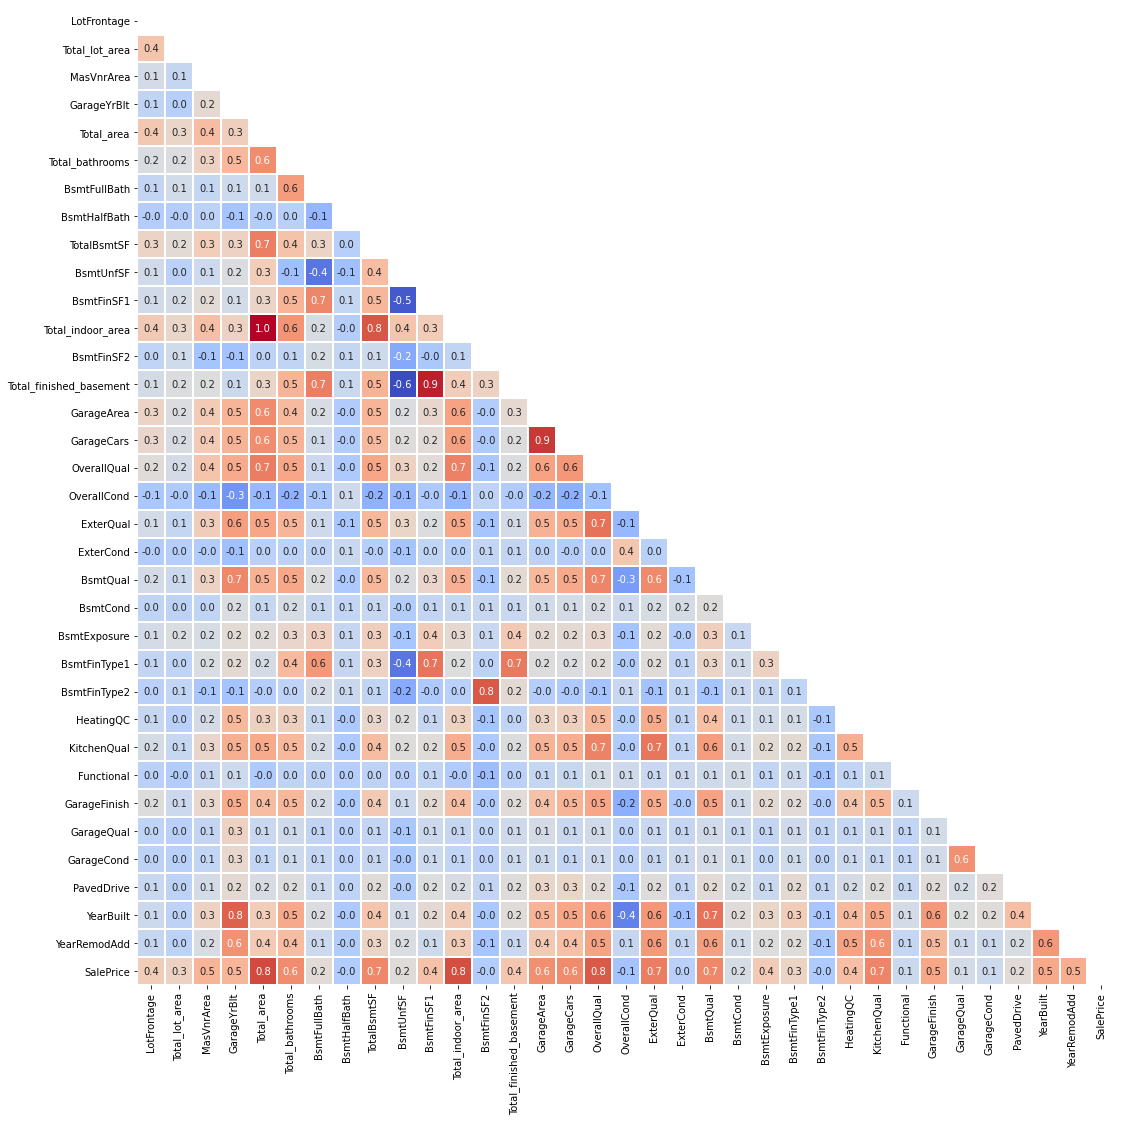

In [1355]:
# compute correlation values
corr = df_corr.corr()

#graph
mask = np.triu(corr)
plt.figure(figsize=(18, 18))
sns.heatmap(corr,
            annot=True,
            fmt='.1f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False)

The last row shows the correlation values of different attributes with the sale price. As can be seen, some attributes (dark red) are positively correlation with the sale prices, whereas others (dark blue) are negatively correlated. In the meantime, some attributes have zero correlation with the sale price, meaning they will bring almost no explanatory power in our predictive model. Also, there are a few strong correlations within the explanatory variables, which may cause multicollinearity in regression models. 

# Prepararation of datasets for modelling <a class="anchor" id="9-bullet"></a>

To begin with, let's check for outliers and remove them.

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

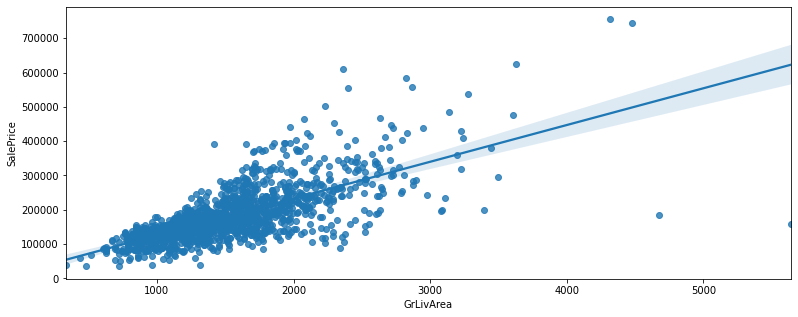

In [1147]:
# check for outliers
plt.figure(figsize=(13,5))
sns.regplot(x=train['GrLivArea'], y=train['SalePrice'])

<AxesSubplot:xlabel='SalePrice'>

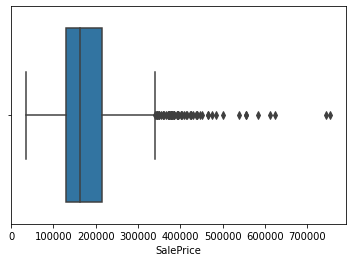

In [1149]:
# check for the 2 outlier sales price datapoints in a boxplot
sns.boxplot(x=train['SalePrice'])

In [1150]:
# capture four outliers
outliers = np.where(train['GrLivArea'] > 4500)[0]
outliers

array([ 523, 1298], dtype=int64)

In [1153]:
#drop the outliers from the train set
train = train.drop(train.index[outliers])

Next, prepare the training and test datasets by removing the unused attributes and making sure the data types are consistent.

In [1154]:
# convert all columns to float
SalePrice = train['SalePrice']
X = train.drop(["Id", "SalePrice"], axis = 1, inplace = False).astype(float)

# targets 
y = SalePrice.values

# set for Kaggle prediction
X_test = test.drop(["Id", "SalePrice"], axis = 1, inplace = False).astype(float)

In [1362]:
# Now the number of attributes in train and test sets should match
X.shape, X_test.shape

((1456, 221), (1459, 221))

# Unsupervised learning <a class="anchor" id="10-bullet"></a>

## Principal component analysis <a class="anchor" id="11-bullet"></a>

First, I appply Principal component analysis (PCA) to the training dataset. PCA is an unsupervised technique helps reduce the dimensionality of high-dimensional datasets while preserving the original structure and relationships inherent to the original dataset. 

>1 0.535 (0.105)
>2 0.602 (0.087)
>3 0.664 (0.098)
>4 0.687 (0.086)
>5 0.737 (0.066)
>6 0.745 (0.063)
>7 0.754 (0.060)
>8 0.756 (0.055)
>9 0.757 (0.061)
>10 0.753 (0.063)


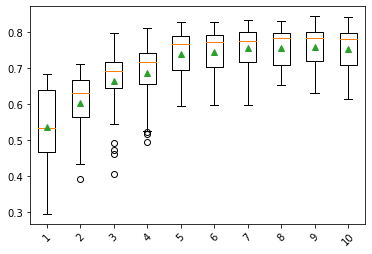

In [1158]:
#ignore warnings
warnings.simplefilter('ignore')

# get a list of models to evaluate
def get_models():
    models = dict()

    for i in range(1, 11):
        steps = [('scaler', MinMaxScaler()), ('pca', PCA(n_components=i)), ('m', GradientBoostingRegressor(random_state = 10))]
        models[str(i)] = Pipeline(steps=steps)
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score=np.nan)
    return scores
 
# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

warnings.simplefilter('default')

As can be seen above, the explained variance ratio starts to level off after 5 components and reaches a peak at 8 components. Next, I'll use 8 components to do k-means clustering. 

## KMeans clustering <a class="anchor" id="13-bullet"></a>

Next, I apply the k-means clustering method to the selected components from the PCA analysis. Using K-means clustering, my objective is to identify clusters of houses with similar charateristics. 

In [1164]:
# merge explanatory attributes and target values for cluster analysis
df_kmeans = X.merge(pd.Series(y).rename('SalePrice'), left_index=True, right_index=True)

# keep column names which will be necessary after scaling the dataset
df_kmeans_columns = df_kmeans.columns

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [1165]:
# scale the dataset 
df_kmeans = MinMaxScaler().fit_transform(df_kmeans)

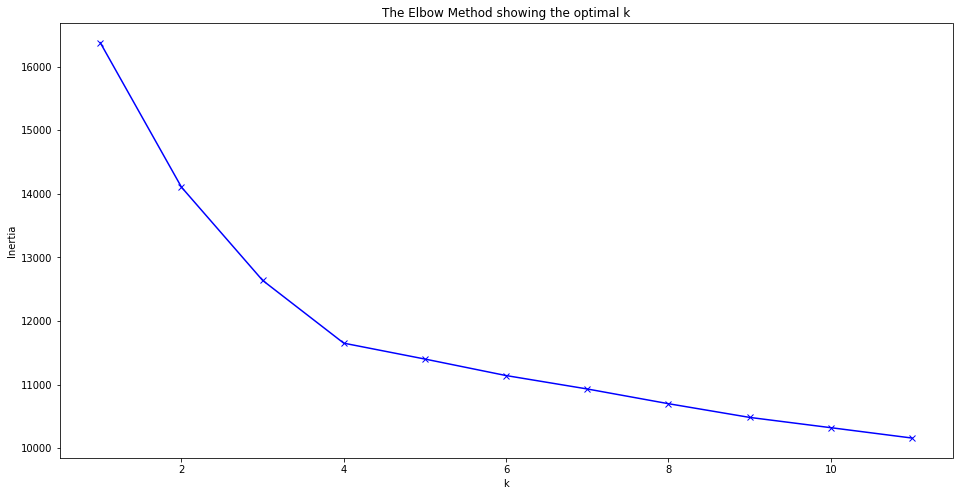

In [1216]:
# identify the opminal number of clusters using the elbow method
inertia = []
K = range(1,12)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state = 42)
    kmeanModel.fit(df_kmeans)
    inertia.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [1217]:
# run k-means clustering with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=0).fit(df_kmeans)

#get labels
labels = kmeans.labels_

#merge labels 
df_kmeans = pd.DataFrame(df_kmeans, columns = df_kmeans_columns)
df_kmeans = df_kmeans.merge(pd.Series(labels).rename('Labels'), left_index=True, right_index=True)

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [1218]:
#check how the four clusters divide the dataset 
df_kmeans['Labels'].value_counts()

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



3    458
1    393
2    315
0    286
Name: Labels, dtype: int64

In [1219]:
# the highest correlated attributes with price
high_corr = corr['SalePrice'][abs(corr['SalePrice'])> 0.6].sort_values().index

In [1220]:
# compare cluster differences across all features
table_all = round(df_kmeans.groupby('Labels').mean().sort_values('SalePrice'),3)
table_all

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,Total_baths,Total_lot_area,Total_porch_area,Total_finished_basement,Pool_dummy,2floor_dummy,Garage_dummy,Basement_dummy,Fireplace_dummy,SalePrice
Labels,,,,,,,,,,,,,,,,,,,,,
1,0.131,0.031,0.486,0.616,0.479,0.384,0.023,0.360,0.527,0.371,...,0.435,0.032,0.139,0.097,0.003,0.735,0.878,0.959,0.328,0.173
3,0.181,0.052,0.483,0.597,0.671,0.425,0.049,0.365,0.527,0.416,...,0.390,0.045,0.150,0.274,0.007,0.048,0.937,0.959,0.472,0.183
0,0.169,0.038,0.693,0.507,0.939,0.879,0.095,0.643,0.510,0.742,...,0.539,0.039,0.206,0.283,0.000,0.000,0.986,1.000,0.612,0.235
2,0.189,0.048,0.671,0.538,0.888,0.779,0.109,0.576,0.513,0.661,...,0.711,0.045,0.230,0.191,0.006,1.000,1.000,0.994,0.775,0.238


In terms of prices, there are two main categories in the clusters. Clusters 0 and 1 are similarly low priced, whereas clusters 2 and 3 are similarly high priced

In [1241]:
# the highest relative differences in attributes between cluster 2 and 0
differ = pd.DataFrame(table_all.loc[2]/table_all.loc[1], columns = ['Value']).sort_values('Value', ascending = False).head(20)
differ

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Value
SaleType_Con,inf
Condition1_RRNe,inf
Neighborhood_CollgCr,inf
Neighborhood_NoRidge,inf
Neighborhood_NridgHt,inf
Exterior2nd_AsphShn,inf
Neighborhood_StoneBr,inf
Neighborhood_Timber,inf
Neighborhood_Veenker,inf
Condition1_PosA,inf


In [1356]:
#check how the highest correlated numerical attributes are different across the four clusters
table_highcorr = round(df_kmeans.groupby('Labels')[high_corr].mean().sort_values('SalePrice'),3)
table_highcorr

,TotalBsmtSF,GarageArea,Total_bathrooms,GarageCars,BsmtQual,KitchenQual,ExterQual,Total_indoor_area,OverallQual,Total_area,SalePrice
Labels,,,,,,,,,,,
1,0.238,0.248,0.149,0.327,0.371,0.394,0.360,0.281,0.486,0.285,0.173
3,0.333,0.306,0.190,0.383,0.416,0.400,0.365,0.304,0.483,0.290,0.183
0,0.463,0.435,0.299,0.568,0.742,0.691,0.643,0.406,0.693,0.385,0.235
2,0.310,0.416,0.378,0.556,0.661,0.618,0.576,0.405,0.671,0.425,0.238


In [1228]:
#difference between high and low price clusters
pd.DataFrame(table_highcorr.loc[2]/table_highcorr.loc[1], columns = ['Value']).sort_values('Value', ascending = False)

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Value
Total_bathrooms,2.536913
BsmtQual,1.781671
GarageCars,1.700306
GarageArea,1.677419
ExterQual,1.600000
KitchenQual,1.568528
Total_area,1.491228
Total_indoor_area,1.441281
OverallQual,1.380658
SalePrice,1.375723


In [1229]:
#difference between 2 high price clusters
pd.DataFrame(table_highcorr.loc[2]/table_highcorr.loc[0], columns = ['Value']).sort_values('Value', ascending = False)

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Value
Total_bathrooms,1.264214
Total_area,1.103896
SalePrice,1.012766
Total_indoor_area,0.997537
GarageCars,0.978873
OverallQual,0.968254
GarageArea,0.956322
ExterQual,0.895801
KitchenQual,0.894356
BsmtQual,0.890836


In [1230]:
#difference between 2 low price clusters
pd.DataFrame(table_highcorr.loc[3]/table_highcorr.loc[1], columns = ['Value']).sort_values('Value', ascending = False)

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Value
TotalBsmtSF,1.399160
Total_bathrooms,1.275168
GarageArea,1.233871
GarageCars,1.171254
BsmtQual,1.121294
Total_indoor_area,1.081851
SalePrice,1.057803
Total_area,1.017544
KitchenQual,1.015228
ExterQual,1.013889


C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<AxesSubplot:xlabel='Labels'>

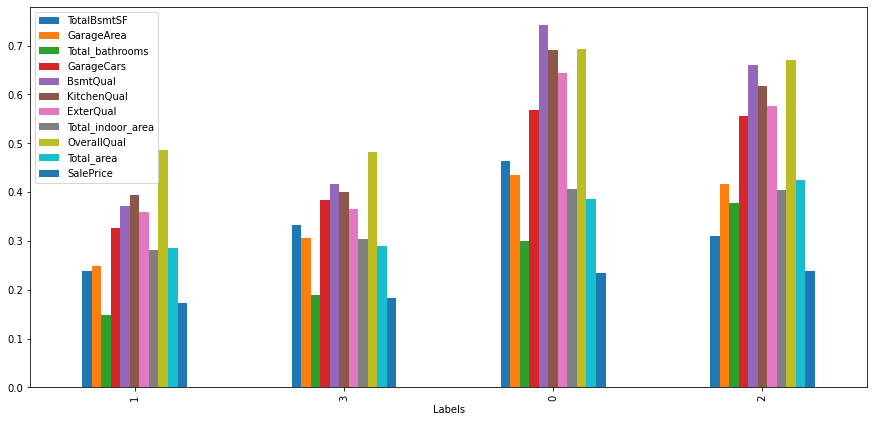

In [1226]:
table_highcorr.plot.bar(figsize=(15,7))

Clusters: <br><br>

Clusters 0 and 2 are close in price and total area <br>
Cluster 0: expensive segment, more bathrooms <br>
Cluster 2: expensive segment, large basement <br>

Clusters 1 and 3 are close in price and total area <br>
Cluster 3: cheaper segment, more basement and bathroom <br>
Cluster 1: cheaper segment, all attributes inferior to cluster 3 <br><br>

Overall, clusters 0 and 2 houses are more expensive, bigger, and better quality than clusters 1 and 3.

In [1244]:
# dataset for 3d graphing
df_3d = df_cluster_analysis[['Total_bathrooms', 'BsmtQual', 'SalePrice', 'Labels']]

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [1243]:
# Visualize cluster shapes in 3d.
init_notebook_mode(connected=True) 

cluster1=df_3d.loc[df_3d['Labels'] == 1]
cluster2=df_3d.loc[df_3d['Labels'] == 2]

scatter1 = dict(
    mode = "markers",
    name = "Cluster 0",
    type = "scatter3d",    
    x = cluster1.iloc[:,0], y = cluster1.iloc[:,1], z = cluster1.iloc[:,2],
    marker = dict( size=2, color='green')
)

scatter2 = dict(
    mode = "markers",
    name = "Cluster 2",
    type = "scatter3d",    
    x = cluster2.iloc[:,0], y = cluster2.iloc[:,1], z = cluster2.iloc[:,2],
    marker = dict( size=2, color='red')
)

cluster1 = dict(
    alphahull = 5,
    name = "Cluster 0",
    opacity = .1,
    type = "mesh3d",    
    x = cluster1.iloc[:,0], y = cluster1.iloc[:,1], z = cluster1.iloc[:,2],
    color='green', showscale = True
)

cluster2 = dict(
    alphahull = 5,
    name = "Cluster 2",
    opacity = .1,
    type = "mesh3d",    
    x = cluster2.iloc[:,0], y = cluster2.iloc[:,1], z = cluster2.iloc[:,2],
    color='red', showscale = True
)

layout = dict(
    title = '3D mapping of expensive and cheap clusters',
    scene = dict(
        xaxis = dict( zeroline=True ),
        yaxis = dict( zeroline=True ),
        zaxis = dict( zeroline=True ),
        xaxis_title='Bathrooms',
        yaxis_title='Basement',
        zaxis_title='Sale price')
    )
fig = dict(data=[scatter1, scatter2, cluster1, cluster2], layout=layout )

# saves and launches html file with the 3D vizualization
py.plot(fig,layout,filename='3D.html')

'3D.html'

# Supervised learning <a class="anchor" id="14-bullet"></a>

## Feature selection <a class="anchor" id="15-bullet"></a>

First, I reduce the number of features using recursive feature elimination (RFE).To do this, I evaluate a Gradient Boosting Regressor model with different numbers of features and select the number of features that yield the smallest root mean squared error.

>100 -21908.521 (3268.933)
>205 -21877.138 (3314.816)
>208 -21800.031 (3229.133)
>221 -21984.383 (3293.911)


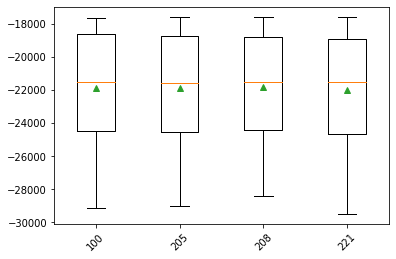

In [1249]:
#use recursive feature elimination (RFE) to select features

warnings.simplefilter('ignore')

# get a list of models to evaluate
def get_models():
    models = dict()

    for i in [100, 205, 208, 221]:
        steps = [('scaler', MinMaxScaler()), ('rfe', RFE(estimator = GradientBoostingRegressor(random_state = 10), n_features_to_select= i))]
        models[str(i)] = Pipeline(steps=steps)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring= 'neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score=np.nan)
    return scores
 
# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

warnings.simplefilter('default')

Reducing the attributes to 208 results in the lowest RMSE. 

In [1250]:
# eliminate features 
estimator = GradientBoostingRegressor(random_state = 10)
selector = RFE(estimator, n_features_to_select=208)
selector = selector.fit(X, y)
selector.support_

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [1255]:
# reduce features based on the RFE selection
X_reduced = X[X.columns[selector.support_]]
X_test_reduced = X_test[X_test.columns[selector.support_]]
X_reduced.shape, X_test_reduced.shape

((1456, 208), (1459, 208))

## Tune Hyperparameters with Randomized Search <a class="anchor" id="17-bullet"></a>

Next, I use RandomizedSearchCV to tune hyperparameters of the model and evaluate different models using cross-validation.

In [1294]:
# pipeline of the scaler and regression model
pipeline_gbr = Pipeline([
        ('scaler', MinMaxScaler()),
        ('GFR', GradientBoostingRegressor())
    ])

# parameters to search on
parameters_gbr = {
        'GFR__random_state': [10],
        'GFR__learning_rate': uniform(0.001, 0.06),
        'GFR__n_estimators': randint(3500, 4200),
        'GFR__subsample': uniform(0.01, 0.8),
        'GFR__max_depth': [4, 5, 6, 9],
        'GFR__criterion': ["friedman_mse", "mse", "mae"], 
        'GFR__tol': [0.001],
        'GFR__n_iter_no_change': [10]
    }

# initiate instance
gs_gbr = RandomizedSearchCV(pipeline_gbr, parameters_gbr, n_iter=80, n_jobs = -1, scoring= 'neg_mean_squared_log_error', cv = 5, verbose=1, random_state =10)

In [1295]:
# random grid search
gs_gbr.fit(X_reduced, y)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 32.2min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 65.9min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                             ('GFR',
                                              GradientBoostingRegressor())]),
                   n_iter=80, n_jobs=-1,
                   param_distributions={'GFR__criterion': ['friedman_mse',
                                                           'mse', 'mae'],
                                        'GFR__learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B98DC5FEC8>,
                                        'GFR__max_depth': [4, 5, 6, 9],
                                        'GFR__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B98DC5F5C8>,
                                        'GFR__n_iter_no_change': [10],
                                        'GFR__random_state': [10],
                                        'GFR__subsample': <scipy.stats._distn_infrastructure.rv_

In [1296]:
#get best parameters
gs_gbr.best_params_

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



{'GFR__criterion': 'mae',
 'GFR__learning_rate': 0.018757702412780724,
 'GFR__max_depth': 6,
 'GFR__n_estimators': 3860,
 'GFR__n_iter_no_change': 10,
 'GFR__random_state': 10,
 'GFR__subsample': 0.27040931026579906,
 'GFR__tol': 0.001}

In [1297]:
# rmse score of the best model
gs_gbr.best_score_

-0.013933917176273583

In [1298]:
# predict for Kaggle submission
pred_gbr = gs_gbr.predict(X_test_reduced)

In [1299]:
# export prediction to a csv file for submission
submission_gbr = pd.DataFrame()
submission_gbr['Id'] = df_test['Id']
submission_gbr['SalePrice'] = pred_gbr
submission_gbr.to_csv('submission_gbr.csv', index=False)

C:\Users\uallakulov\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Evaluation of feature importances <a class="anchor" id="20-bullet"></a>

Finally, I evaluate feature importances by assigning scores to input features in the above model.

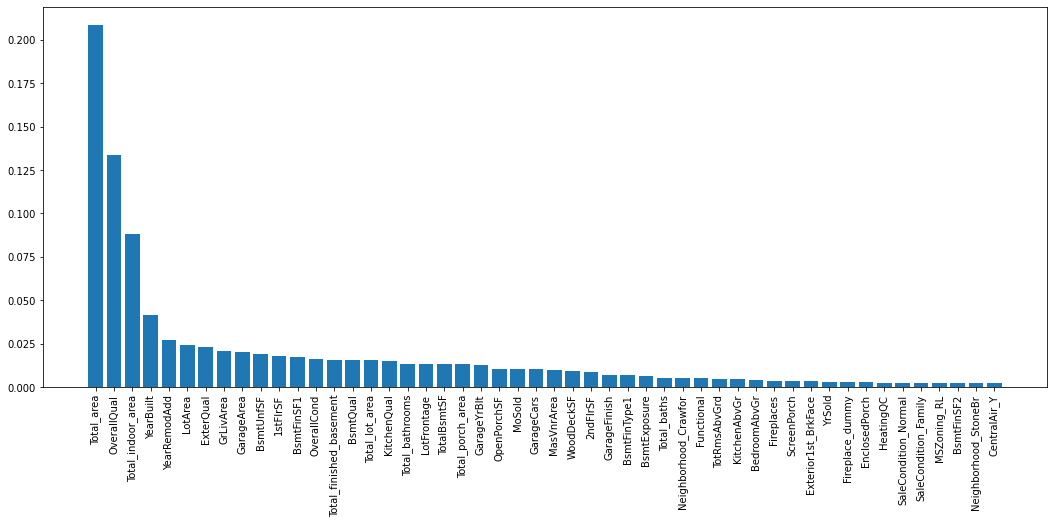

In [1341]:
#get feature importances
importances = gs_gbr.best_estimator_._final_estimator.feature_importances_
#reverse the list - greatest to least important
sorted_index = np.argsort(importances)[::-1]
x = range(0,50)

#tick labels
labels = np.array(X_reduced.columns)[sorted_index]

#plot
plt.figure(figsize=(18,7))
plt.bar(x, importances[sorted_index][0:50], tick_label = labels[0:50])
plt.xticks(rotation = 90)

plt.show()


*End of notebook*